# Explore here

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

PROJECT_ROOT = Path.cwd() if (Path.cwd() / "data").exists() else Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"
MODELS_DIR = PROJECT_ROOT / "models"

DATA_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

CSV_URL = "https://breathecode.herokuapp.com/asset/internal-link?id=809&path=housing.csv"
CSV_PATH = DATA_DIR / "housing.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CSV_PATH:", CSV_PATH)
# Your code here

PROJECT_ROOT: /workspaces/mati-k-means-project
CSV_PATH: /workspaces/mati-k-means-project/data/housing.csv


In [2]:
df = pd.read_csv(CSV_URL)
df.to_csv(CSV_PATH, index=False)

print(df.shape)
print(df.columns.tolist())
df.head()


(20640, 9)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
cols = ["Latitude", "Longitude", "MedInc"]
df = df[cols].copy()

for c in cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna()

print(df.shape)
df.head()


(20640, 3)


,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462


In [4]:
X = df[cols]

X_train_raw, X_test_raw = train_test_split(
    X,
    test_size=0.2,
    random_state=RANDOM_STATE
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print(X_train.shape, X_test.shape)


(16512, 3) (4128, 3)


In [5]:
k = 6
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
kmeans.fit(X_train)

train_clusters = kmeans.predict(X_train)
test_clusters = kmeans.predict(X_test)

print("Train clusters unique:", np.unique(train_clusters))
print("Test clusters unique:", np.unique(test_clusters))


Train clusters unique: [0 1 2 3 4 5]
Test clusters unique: [0 1 2 3 4 5]


In [6]:
train_df = X_train_raw.copy()
train_df["cluster"] = train_clusters.astype(int)

test_df = X_test_raw.copy()
test_df["cluster"] = test_clusters.astype(int)

train_df.head()


,Latitude,Longitude,MedInc,cluster
14196,32.71,-117.03,3.2596,5
8267,33.77,-118.16,3.8125,5
17445,34.66,-120.48,4.1563,0
14265,32.69,-117.11,1.9425,5
2271,36.78,-119.80,3.5542,0


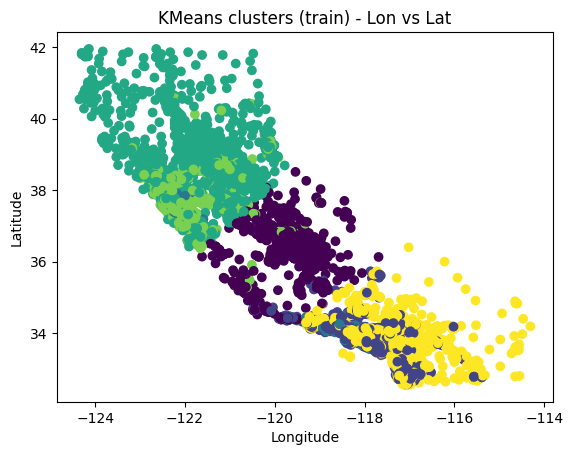

In [7]:
plt.figure()
plt.scatter(train_df["Longitude"], train_df["Latitude"], c=train_df["cluster"])
plt.title("KMeans clusters (train) - Lon vs Lat")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


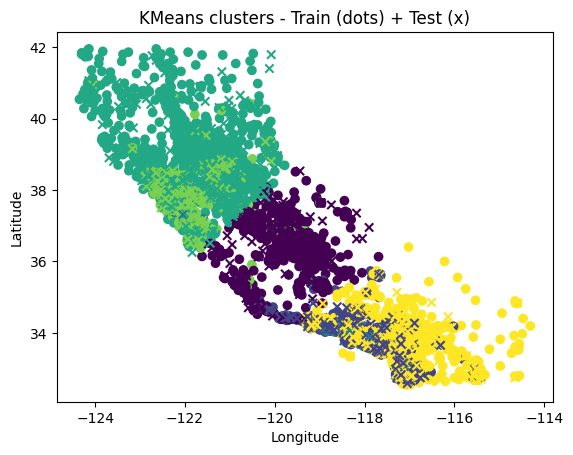

In [8]:
plt.figure()
plt.scatter(train_df["Longitude"], train_df["Latitude"], c=train_df["cluster"])
plt.scatter(test_df["Longitude"], test_df["Latitude"], c=test_df["cluster"], marker="x")
plt.title("KMeans clusters - Train (dots) + Test (x)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [9]:
X_train_sup = train_df[cols]
y_train_sup = train_df["cluster"]

X_test_sup = test_df[cols]
y_test_sup = test_df["cluster"]

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf.fit(X_train_sup, y_train_sup)
pred = rf.predict(X_test_sup)

acc = accuracy_score(y_test_sup, pred)
print("Accuracy:", acc)

print("\nConfusion matrix:\n", confusion_matrix(y_test_sup, pred))
print("\nReport:\n", classification_report(y_test_sup, pred))


Accuracy: 0.9953972868217055

Confusion matrix:
 [[ 332    1    0    3    1    0]
 [   0  827    0    0    0    2]
 [   0    2  110    0    0    0]
 [   1    0    0  956    5    0]
 [   0    0    0    3  511    0]
 [   0    1    0    0    0 1373]]

Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       337
           1       1.00      1.00      1.00       829
           2       1.00      0.98      0.99       112
           3       0.99      0.99      0.99       962
           4       0.99      0.99      0.99       514
           5       1.00      1.00      1.00      1374

    accuracy                           1.00      4128
   macro avg       1.00      0.99      0.99      4128
weighted avg       1.00      1.00      1.00      4128



In [10]:
kmeans_path = MODELS_DIR / "housing_kmeans.joblib"
scaler_path = MODELS_DIR / "housing_scaler.joblib"
rf_path = MODELS_DIR / "housing_cluster_classifier.joblib"

joblib.dump(kmeans, kmeans_path)
joblib.dump(scaler, scaler_path)
joblib.dump(rf, rf_path)

print("KMeans guardado en:", kmeans_path)
print("Scaler guardado en:", scaler_path)
print("Classifier guardado en:", rf_path)


KMeans guardado en: /workspaces/mati-k-means-project/models/housing_kmeans.joblib
Scaler guardado en: /workspaces/mati-k-means-project/models/housing_scaler.joblib
Classifier guardado en: /workspaces/mati-k-means-project/models/housing_cluster_classifier.joblib
